## Analisi communities leiden - IG:
* [Funzioni](#funzioni)
* [Rete menzioni](#Rete-menzioni)  
    * [Analisi della componente più connessa](#Componente-connessa)
    * [Analisi dell\'intero grafo](#grafo-completo)
    
* [Rete globale](#Rete-globale)
    * [Analisi della componente più connessa 2](#Componente-più-connessa)
    * [Analisi sul grafo intero](#analisi-sul-grafo-intero)

In [1]:
import json
import networkx as nx
import re
import csv
import math
from collections import defaultdict

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import powerlaw
warnings.filterwarnings('ignore')

In [3]:
path = r'C:\Users\naomi\Documents\tesi 2025\prova ufficiale\dataset\\'

output_path = r"C:\Users\naomi\Documents\tesi 2025\prova ufficiale\grafi\IG\healthy\rete commenti sotto lo stesso post\\"

In [4]:
file_edge_mention = 'mentions_directed_network_from_comments_healthy_IG_with_account_nuovo.edgelist'
file_node_att_mention =  'nodes_attributes_healthy_IG_nuovo.json'
file_leiden_mention_cc = 'communities_leiden_healthy_IG_connected_component_MENTIONS_nuovo.json'
file_leiden_mention_all = 'communities_leiden_healthy_IG_all_graph_MENTIONS_nuovo.json'

file_edge_global = 'healthy_IG_global_weight_big_graph.edgelist'
file_node_att_global = 'nodes_attributes_healthy_IG_nuovo.json'
file_leiden_global_cc = 'communities_leiden_healthy_IG_connected_component_GLOBAL_big_graph.json'
file_leiden_global_all = 'communities_leiden_healthy_IG_all_graph_GLOBAL_big_graph.json'

#### funzioni

In [5]:
def apri_grafo(percorso, nome_file1, nome_file2):
    g = nx.Graph()
    with open(percorso+nome_file1) as f:
        for l in f:
            l = l.rsplit()
            if len(l)==3:
                g.add_edge(l[0], l[1], weight=float(l[2]))
    
    
    with open(percorso + nome_file2, 'r') as f:
        node_data = json.load(f)
    
    # Aggiungi attributi ai nodi presenti nella rete
    for node, attributes in node_data.items():
        if node in g.nodes:
            g.nodes[node].update(attributes)
    
    print("Nodi nella rete:", g.number_of_nodes())
    print("Archi nella rete:", g.number_of_edges())
    return g, node_data

In [6]:
def apri_communities(percorso, nome_file):
    with open(percorso+nome_file, 'r', encoding='utf-8') as f:
        communities_leiden = json.load(f)
    return communities_leiden

In [7]:
def communities_dct_stat(communities_leiden, g):
    numeric_attributes = [
    'n_comments', 'n_mentions', 'n_unique_mentions', 'n_mentioned_accounts',
    'negative_comment_count', 'neutral_comment_count', 'positive_comment_count',
    'negative_comment_percentage', 'neutral_comment_percentage', 'positive_comment_percentage',
    'avg_hate', 'avg_toxicity', 'emoji_count', 'emoji_ratio' ]

    community_dct_attributes = {}
    
    for community_id, user_community in communities_leiden.items():
        # Accumulatori per media e std
        sums = defaultdict(float)
        sums_sq = defaultdict(float)
        counts = defaultdict(int)
    
        total_comments_sum = 0
        valid_users = 0
    
        for user in user_community:
            if user not in g.nodes:
                continue
    
            user_data = g.nodes[user]
            valid_users += 1
    
            # Somma totale commenti
            if 'n_comments' in user_data and isinstance(user_data['n_comments'], (int, float)):
                total_comments_sum += user_data['n_comments']
    
            # Accumula per media e std
            for attr in numeric_attributes:
                if attr in user_data and isinstance(user_data[attr], (int, float)):
                    val = user_data[attr]
                    sums[attr] += val
                    sums_sq[attr] += val * val
                    counts[attr] += 1
    
        # Calcolo media e deviazione standard
        numeric_stats = {}
        for attr in numeric_attributes:
            n = counts[attr]
            if n > 1:
                mean = sums[attr] / n
                variance = (sums_sq[attr] - n * mean * mean) / (n - 1)
                std = math.sqrt(variance) if variance >= 0 else 0.0
                numeric_stats[attr] = {'mean': mean, 'std': std}
            elif n == 1:
                mean = sums[attr] / n
                numeric_stats[attr] = {'mean': mean, 'std': 0.0}
            else:
                numeric_stats[attr] = {'mean': None, 'std': None}
    
        # Salva le statistiche per la community
        community_dct_attributes[community_id] = {
            'total_comments_sum': total_comments_sum,
            'numeric_stats': numeric_stats,
            'valid_users': valid_users,
            'total_users': len(user_community)
        }
    return community_dct_attributes

In [8]:
def box_plot(communities_leiden, g):
    # Attributi numerici da analizzare
    attributes = [
        'negative_comment_percentage', 'neutral_comment_percentage', 'positive_comment_percentage', 
        'avg_hate', 'avg_toxicity', 'emoji_ratio',
    ]
    
    # Raccogli dati per ogni attributo e community
    attribute_data = {attr: [] for attr in attributes}
    
    for attr in attributes:
        for community_users in communities_leiden.values():
            values = []
            for user in community_users:
                if user in g.nodes and attr in g.nodes[user]:
                    val = g.nodes[user][attr]
                    if isinstance(val, (int, float)):
                        values.append(val)
            attribute_data[attr].append(values)
    
    # Plot: un grafico per ogni attributo
    n_attrs = len(attributes)
    fig, axes = plt.subplots(n_attrs, 1, figsize=(14, 4 * n_attrs), sharex=False)
    
    if n_attrs == 1:
        axes = [axes]
    
    for i, attr in enumerate(attributes):
        ax = axes[i]
        
        # Calcola la mediana per ogni community
        medians = [np.median(comm_data) if comm_data else float('-inf') for comm_data in attribute_data[attr]]
        
        # Ottieni gli indici ordinati per mediana decrescente
        sorted_indices = sorted(range(len(medians)), key=lambda i: medians[i], reverse=True)
        
        # Riordina i dati
        sorted_data = [attribute_data[attr][i] for i in sorted_indices]
        
        # Etichette ordinate
        sorted_labels = [f'Comm {i}' for i in sorted_indices]
        
        # Boxplot
        ax.boxplot(sorted_data,
                   patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='blue'),
                   medianprops=dict(color='red'),
                   whiskerprops=dict(color='blue'),
                   capprops=dict(color='blue'),
                   flierprops=dict(marker='o', markerfacecolor='orange', markersize=5, linestyle='none'))
    
        ax.set_title(f'{attr} - distribuzione per community (ordinate per mediana)')
        ax.set_ylabel(attr)
        ax.set_xlabel('Community')
        ax.set_xticks(range(1, len(sorted_data) + 1))
        ax.set_xticklabels(sorted_labels, rotation=45, ha='right')
        ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

In [9]:
def info_communities_negative_nodes(communities_leiden, node_data):
    community_stats = {}

    for community_id, node_list in communities_leiden.items():
        total_nodes = len(node_list)
        negative_nodes = sum(1 for node_id in node_list if node_data.get(node_id, {}).get('node_label') == 'negative')
        percentage = (negative_nodes / total_nodes) * 100 if total_nodes > 0 else 0
    
        community_stats[community_id] = {
            'total_nodes': total_nodes,
            'negative_nodes': negative_nodes,
            'percentage_negative': round(percentage, 2)
        }
    
    # Stampa i risultati
    print("\n📊 Distribution of negative nodes per community:")
    for cid, stats in community_stats.items():
        print(f"  Community {cid}: {stats['negative_nodes']} / {stats['total_nodes']} "
              f"({stats['percentage_negative']}% negative)")
    return community_stats

In [10]:
def avg_edge_weight_per_community(communities_leiden, g):
    average_edge_weight_per_community = {}
    
    for community_id, node_list in communities_leiden.items():
        weights = []
        for u in node_list:
            for v in g.neighbors(u):
                if v in node_list:  # solo archi interni alla community
                    weight = g[u][v].get('weight', 1)  # default weight = 1
                    weights.append(weight)
        if weights:
            avg_weight = sum(weights) / len(weights)
        else:
            avg_weight = 0
        average_edge_weight_per_community[community_id] = avg_weight
    return average_edge_weight_per_community

In [11]:
def double_plot(community_stats, average_edge_weight_per_community):
    
    # Dati
    community_ids = sorted(community_stats.keys(), key=lambda x: int(x))
    total_counts = [community_stats[c]['total_nodes'] for c in community_ids]
    negative_counts = [community_stats[c]['negative_nodes'] for c in community_ids]
    percent_negative = [community_stats[c]['percentage_negative'] for c in community_ids]
    x_avg_weights = [average_edge_weight_per_community[c] for c in community_ids]
    sizes = [count / 5 for count in total_counts]  # adatta il divisore se necessario
    
    # Imposta figura con due subplot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
    
    # --- Primo scatterplot: dimensione vs. nodi negativi
    axes[0].scatter(total_counts, negative_counts, s=sizes, color='blue', alpha=0.7, edgecolors='k')
    axes[0].set_title('Community size vs. Number of negative nodes')
    axes[0].set_xlabel('Total nodes in the community')
    axes[0].set_ylabel('Number of negative nodes')
    axes[0].grid(True)
    
    # Aggiungi etichette sopra ogni punto
    for i, cid in enumerate(community_ids):
        axes[0].text(total_counts[i], negative_counts[i] + 0.5, cid, ha='center', fontsize=8)
    
    # --- Secondo scatterplot: peso medio vs. % nodi negativi
    axes[1].scatter(x_avg_weights, percent_negative, s=sizes, color='purple', alpha=0.7, edgecolors='k')
    axes[1].set_title('Average edge weight vs. Percentage of negative nodes')
    axes[1].set_xlabel('Average edge weight in the community')
    axes[1].set_ylabel('Percentage of negative nodes (%)')
    axes[1].grid(True)
    
    # Aggiungi etichette sopra ogni punto
    for i, cid in enumerate(community_ids):
        axes[1].text(x_avg_weights[i], percent_negative[i] + 0.5, cid, ha='center', fontsize=8)
    
    # Titolo globale
    plt.suptitle('Community metrics and their relation to negativity', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [12]:
import os
import matplotlib.pyplot as plt

def single_plot(community_stats, average_edge_weight_per_community, name_fig, description=None, save_path=None):
    """
    This function generates a scatter plot comparing the average edge weight and the community size.
    Each point represents a community.
    - The color indicates the percentage of negative nodes.
    - The size of the points is proportional to the percentage of negative nodes.
    
    Parameters:
    ----------
    community_stats : dict
        Dictionary containing statistics for each community (e.g., total_nodes, percentage_negative).
    average_edge_weight_per_community : dict
        Dictionary containing the average edge weight for each community.
    name_fig : str
        Name of the figure to be saved.
    save_path : str, optional
        Path where the figure will be saved (default: None).
    """
    
    # Create output directory if specified
    if save_path:
        os.makedirs(save_path, exist_ok=True)
    
    # Sort communities by ID (numeric order)
    community_ids = sorted(community_stats.keys(), key=lambda x: int(x))
    
    # X-axis: average edge weights, Y-axis: community sizes
    x_weights = [average_edge_weight_per_community[c] for c in community_ids]
    y_sizes = [community_stats[c]['total_nodes'] for c in community_ids]
    
    plt.figure(figsize=(12, 5))
    
    # Color and size represent the percentage of negative nodes
    colors = [community_stats[c]['percentage_negative'] for c in community_ids]
    sizes = [community_stats[c]['percentage_negative'] * 10 for c in community_ids]  # Scaled for visibility
    
    # Create scatter plot
    scatter = plt.scatter(x_weights, y_sizes, s=sizes, c=colors, cmap='coolwarm', alpha=0.7, edgecolors='k')
    plt.colorbar(scatter, label='Percentage of negative nodes (%)')
    
    # Label each point with the community ID
    for i, c in enumerate(community_ids):
        plt.text(x_weights[i], y_sizes[i], c, fontsize=9, ha='right', va='bottom')
    
    # Title and axis labels
    plt.title('Average Edge Weight vs. Community Size\n'
              '(Color and Size = % of Negative Nodes)', fontsize=13)
    plt.xlabel('Average Edge Weight')
    plt.ylabel('Community Size (Number of Nodes)')
    
    # Add grid and layout
    plt.grid(True)
    plt.tight_layout()
    
    # Add description below the plot
    plt.figtext(
        0.435, -0.025,
        f"{description}",
        wrap=True, horizontalalignment='center', fontsize=10
    )
    
    # Save figure if path provided
    if save_path:
        plt.savefig(f"{save_path}/{name_fig}_analyses_leiden_.png", dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()


In [13]:
import os
import matplotlib.pyplot as plt

def single_plot(community_stats, average_edge_weight_per_community, name_fig, description=None, save_path=None):
    """
    This function generates a scatter plot comparing the average edge weight and the community size.
    Each point represents a community.
    - The color indicates the percentage of negative nodes.
    - The size of the points is proportional to the percentage of negative nodes.
    
    Parameters:
    ----------
    community_stats : dict
        Dictionary containing statistics for each community (e.g., total_nodes, percentage_negative).
    average_edge_weight_per_community : dict
        Dictionary containing the average edge weight for each community.
    name_fig : str
        Name of the figure to be saved.
    save_path : str, optional
        Path where the figure will be saved (default: None).
    """
    
    # Create output directory if specified
    if save_path:
        os.makedirs(save_path, exist_ok=True)
    
    # Sort communities by ID (numeric order)
    community_ids = sorted(community_stats.keys(), key=lambda x: int(x))
    
    # X-axis: average edge weights, Y-axis: community sizes
    x_weights = [average_edge_weight_per_community[c] for c in community_ids]
    y_sizes = [community_stats[c]['total_nodes'] for c in community_ids]
    
    plt.figure(figsize=(12, 5))
    
    # Color and size represent the percentage of negative nodes
    colors = [community_stats[c]['percentage_negative'] for c in community_ids]
    sizes = [community_stats[c]['percentage_negative'] * 10 for c in community_ids]  # Scaled for visibility
    
    # Create scatter plot with fixed color limits (vmin=0, vmax=100)
    scatter = plt.scatter(x_weights, y_sizes, s=sizes, c=colors, cmap='coolwarm', 
                         alpha=0.7, edgecolors='k', vmin=0, vmax=100)
    plt.colorbar(scatter, label='Percentage of negative nodes (%)')
    
    # Label each point with the community ID
    for i, c in enumerate(community_ids):
        plt.text(x_weights[i], y_sizes[i], c, fontsize=9, ha='right', va='bottom')
    
    # Title and axis labels
    plt.title('Average Edge Weight vs. Community Size\n'
              '(Color and Size = % of Negative Nodes)', fontsize=13)
    plt.xlabel('Average Edge Weight')
    plt.ylabel('Community Size (Number of Nodes)')
    
    # Add grid and layout
    plt.grid(True)
    plt.tight_layout()
    
    # Add description below the plot
    plt.figtext(
        0.435, -0.025,
        f"{description}",
        wrap=True, horizontalalignment='center', fontsize=10
    )
    
    # Save figure if path provided
    if save_path:
        plt.savefig(f"{save_path}/{name_fig}_analyses_leiden_.png", dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()

In [14]:
def plot_3D(community_stats, average_edge_weight_per_community):
    community_ids = sorted(community_stats.keys(), key=lambda x: int(x))
    x_avg_weights = [average_edge_weight_per_community[c] for c in community_ids]
    y_negative_percent = [community_stats[c]['percentage_negative'] for c in community_ids]
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    x = x_avg_weights
    y = y_negative_percent
    z = [community_stats[c]['total_nodes'] for c in community_ids]
    
    sc = ax.scatter(x, y, z, c=y, cmap='coolwarm', s=[size/2 for size in z], alpha=0.7, edgecolors='k')
    
    ax.set_xlabel('Average edge weight')
    ax.set_ylabel('Percentage of negative nodes (%)')
    ax.set_zlabel('Community dimentions')
    plt.colorbar(sc, label='Percentage of negative nodes (%)')
    
    plt.title('Community distribution (3D)')
    plt.show()


In [15]:
def pos_neg_distribution_plot(community_stats):
    community_ids = sorted(community_stats.keys(), key=lambda x: int(x))

    positive_counts = [community_stats[c]['total_nodes'] - community_stats[c]['negative_nodes'] for c in community_ids]
    negative_counts = [community_stats[c]['negative_nodes'] for c in community_ids]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(community_ids, negative_counts, label='Negative', color='red')
    ax.bar(community_ids, positive_counts, bottom=negative_counts, label='Positive', color='green')
    
    ax.set_xlabel("Community ID")
    ax.set_ylabel("Number of nodes")
    ax.set_title("Distribution of positive and negative nodes for communities")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [16]:
def pos_neg_distribution_plot_percent(community_stats):
    data = []
    
    for cid in community_stats:
        total = community_stats[cid]['total_nodes']
        neg = community_stats[cid]['negative_nodes']
        pos = total - neg
        
        neg_pct = 100 * neg / total if total > 0 else 0
        pos_pct = 100 * pos / total if total > 0 else 0
        
        data.append((cid, pos_pct, neg_pct))

    # Ordina per percentuale negativa decrescente
    data.sort(key=lambda x: x[2], reverse=True)

    community_ids = [x[0] for x in data]
    positive_percentages = [x[1] for x in data]
    negative_percentages = [x[2] for x in data]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(community_ids, negative_percentages, label='Negative %', color='red')
    ax.bar(community_ids, positive_percentages, bottom=negative_percentages, label='Positive %', color='green')

    ax.set_xlabel("Community ID (sorted by negative %)")
    ax.set_ylabel("Percentage of nodes")
    ax.set_title("Percentage distribution of positive and negative nodes per community")
    ax.set_ylim(0, 100)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [17]:
def correlation(community_stats):
    community_ids = sorted(community_stats.keys(), key=lambda x: int(x))
    
    total_counts = [community_stats[c]['total_nodes'] for c in community_ids]
    negative_counts = [community_stats[c]['negative_nodes'] for c in community_ids]
    percent_negative = [community_stats[c]['percentage_negative'] for c in community_ids]
    
    corr1 = np.corrcoef(total_counts, negative_counts)[0,1]
    corr2 = np.corrcoef(total_counts, percent_negative)[0,1]
    
    print(f"Correlation between total nodes and negative nodes (absolute count): {corr1:.2f}")
    print(f"Correlation between total nodes and percentage of negative nodes: {corr2:.2f}")

## Rete menzioni

In [18]:
g1, node_data1 = apri_grafo(output_path, file_edge_mention, file_node_att_mention)

Nodi nella rete: 10059
Archi nella rete: 11877


### Componente connessa

In [19]:
largest_ccG = max(nx.connected_components(g1), key=len)

G_connected = g1.subgraph(largest_ccG).copy()
len(G_connected)

8992

In [20]:
leiden_mention_cc = apri_communities(output_path, file_leiden_mention_cc)

In [21]:
leiden_dct_mention_cc = communities_dct_stat(leiden_mention_cc, g1)

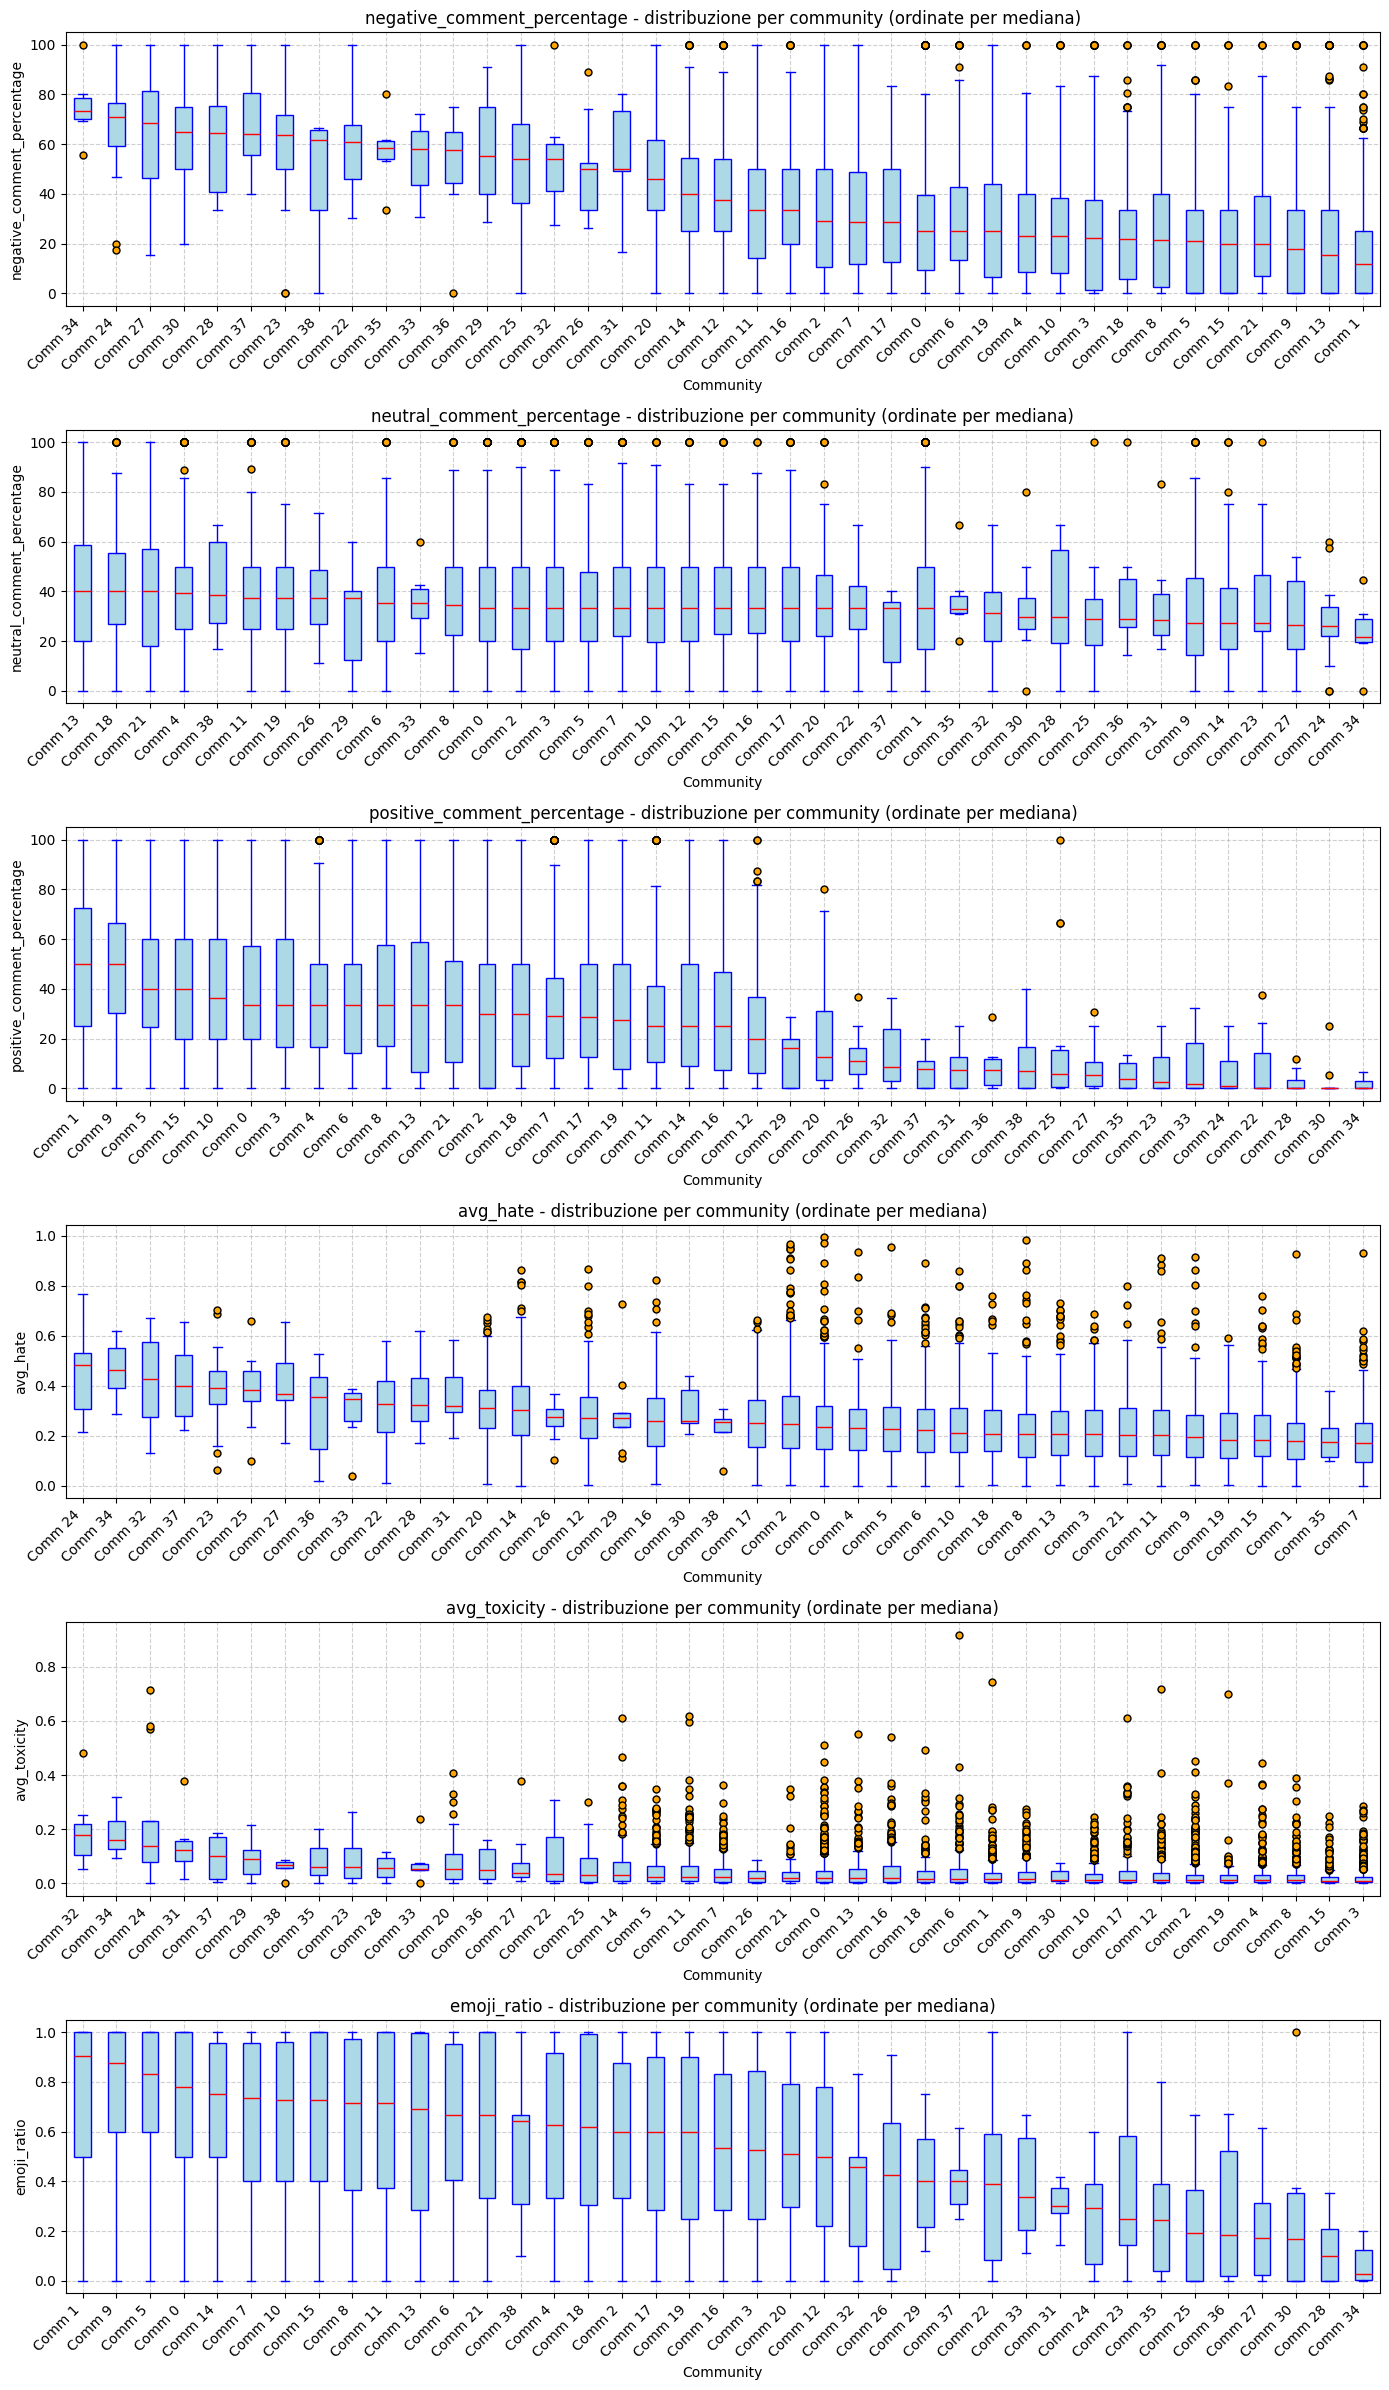

In [22]:
box_plot(leiden_mention_cc, g1)

In [23]:
community_stats_mention_leiden_cc = info_communities_negative_nodes(leiden_mention_cc, node_data1)


📊 Distribution of negative nodes per community:
  Community 0: 269 / 831 (32.37% negative)
  Community 1: 121 / 678 (17.85% negative)
  Community 2: 272 / 643 (42.3% negative)
  Community 3: 212 / 613 (34.58% negative)
  Community 4: 155 / 477 (32.49% negative)
  Community 5: 124 / 467 (26.55% negative)
  Community 6: 169 / 451 (37.47% negative)
  Community 7: 184 / 428 (42.99% negative)
  Community 8: 145 / 418 (34.69% negative)
  Community 9: 83 / 415 (20.0% negative)
  Community 10: 141 / 411 (34.31% negative)
  Community 11: 203 / 402 (50.5% negative)
  Community 12: 236 / 384 (61.46% negative)
  Community 13: 108 / 334 (32.34% negative)
  Community 14: 163 / 287 (56.79% negative)
  Community 15: 62 / 243 (25.51% negative)
  Community 16: 119 / 229 (51.97% negative)
  Community 17: 91 / 212 (42.92% negative)
  Community 18: 66 / 196 (33.67% negative)
  Community 19: 70 / 167 (41.92% negative)
  Community 20: 113 / 155 (72.9% negative)
  Community 21: 30 / 81 (37.04% negative)
  Co

In [24]:
correlation(community_stats_mention_leiden_cc)

Correlation between total nodes and negative nodes (absolute count): 0.91
Correlation between total nodes and percentage of negative nodes: -0.82


In [25]:
avg_edge_leiden_mention_cc = avg_edge_weight_per_community(leiden_mention_cc, g1)

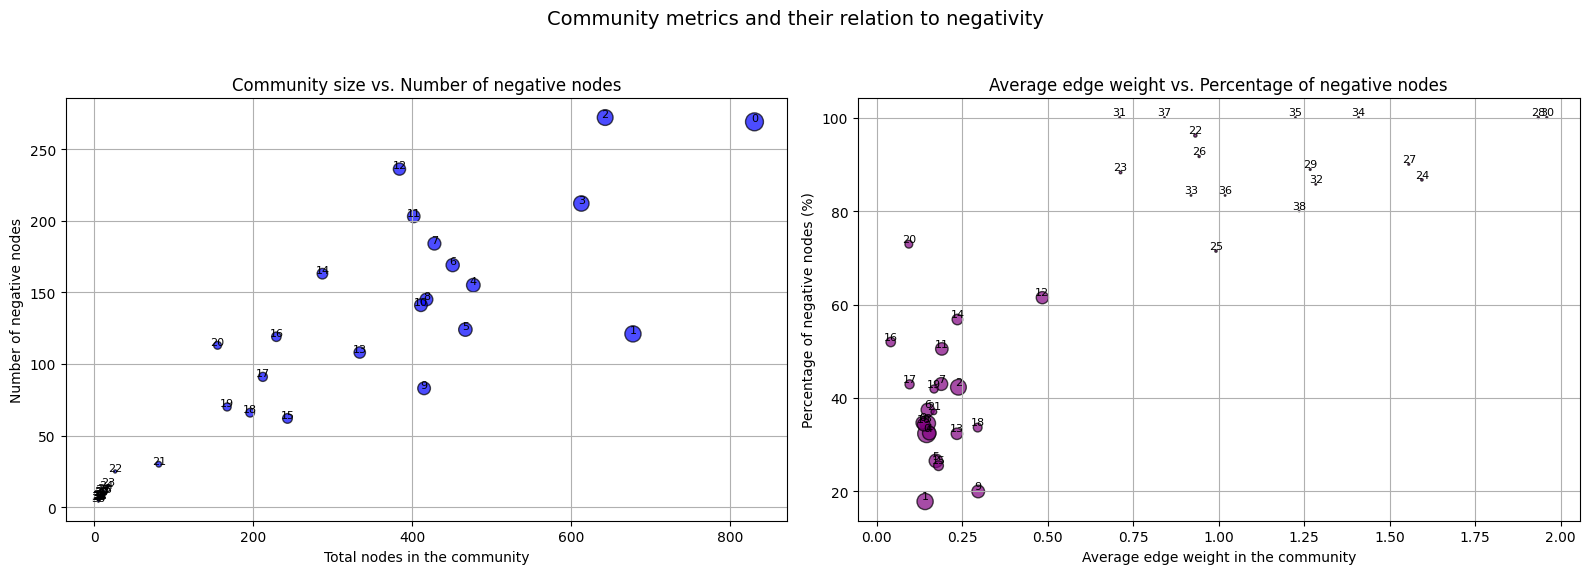

In [26]:
double_plot(community_stats_mention_leiden_cc, avg_edge_leiden_mention_cc)

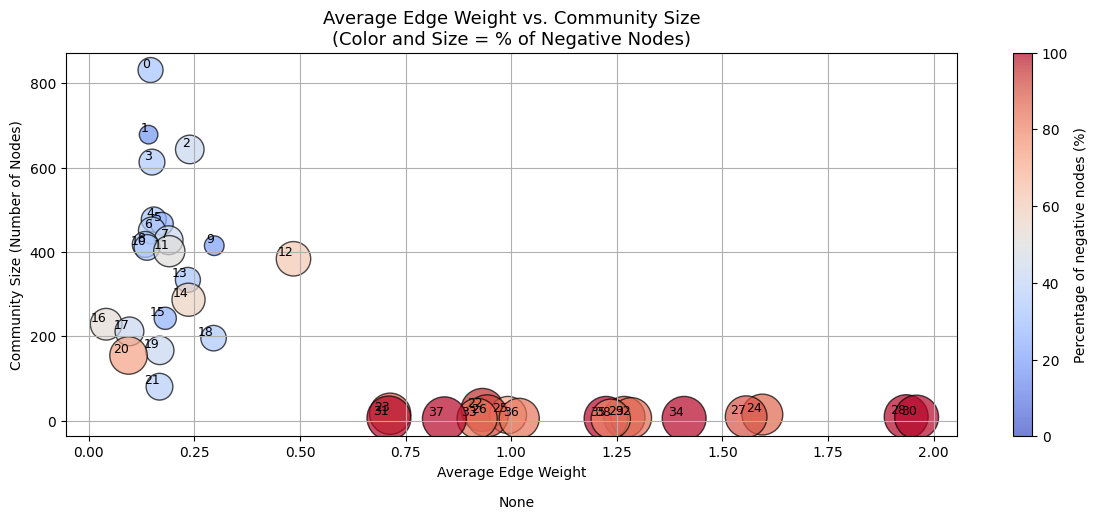

In [28]:
single_plot(community_stats_mention_leiden_cc, avg_edge_leiden_mention_cc, 'plot_healthy_ig_cc')

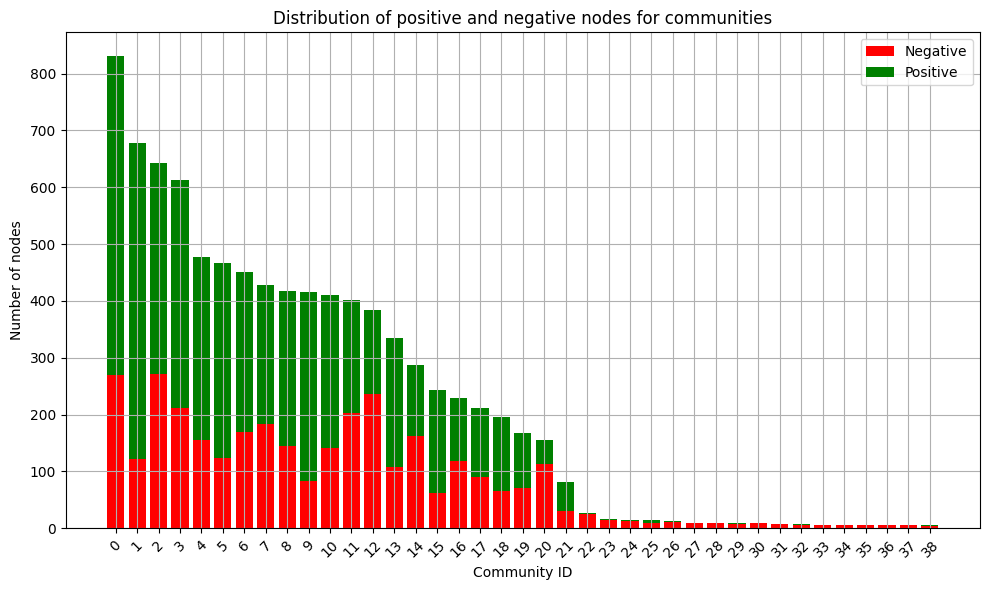

In [29]:
pos_neg_distribution_plot(community_stats_mention_leiden_cc)

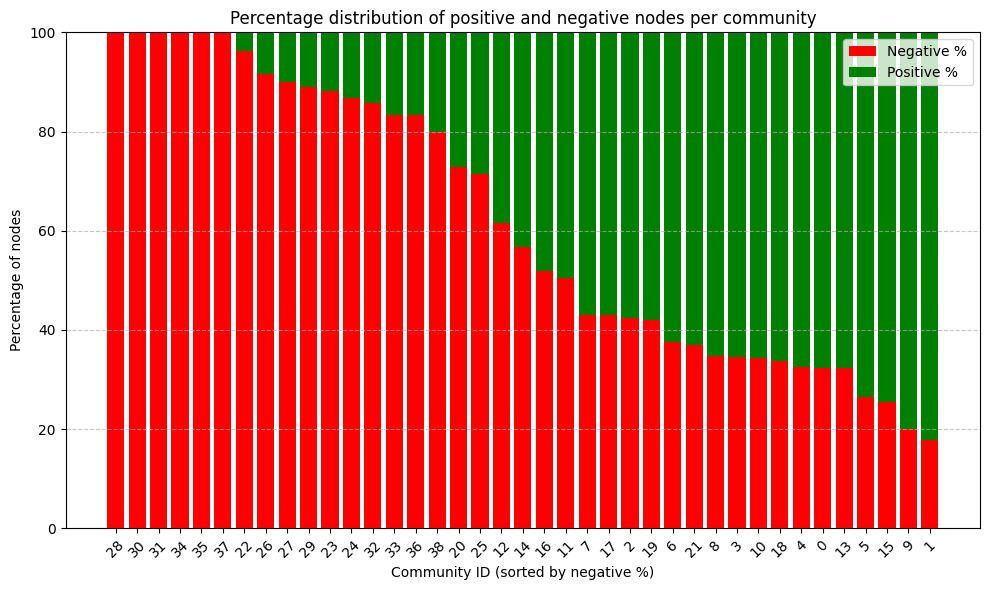

In [30]:
pos_neg_distribution_plot_percent(community_stats_mention_leiden_cc)

### grafo completo

In [31]:
leiden_mention_all = apri_communities(output_path,file_leiden_mention_all)

In [32]:
leiden_dct_mention_all = communities_dct_stat(leiden_mention_all, g1)

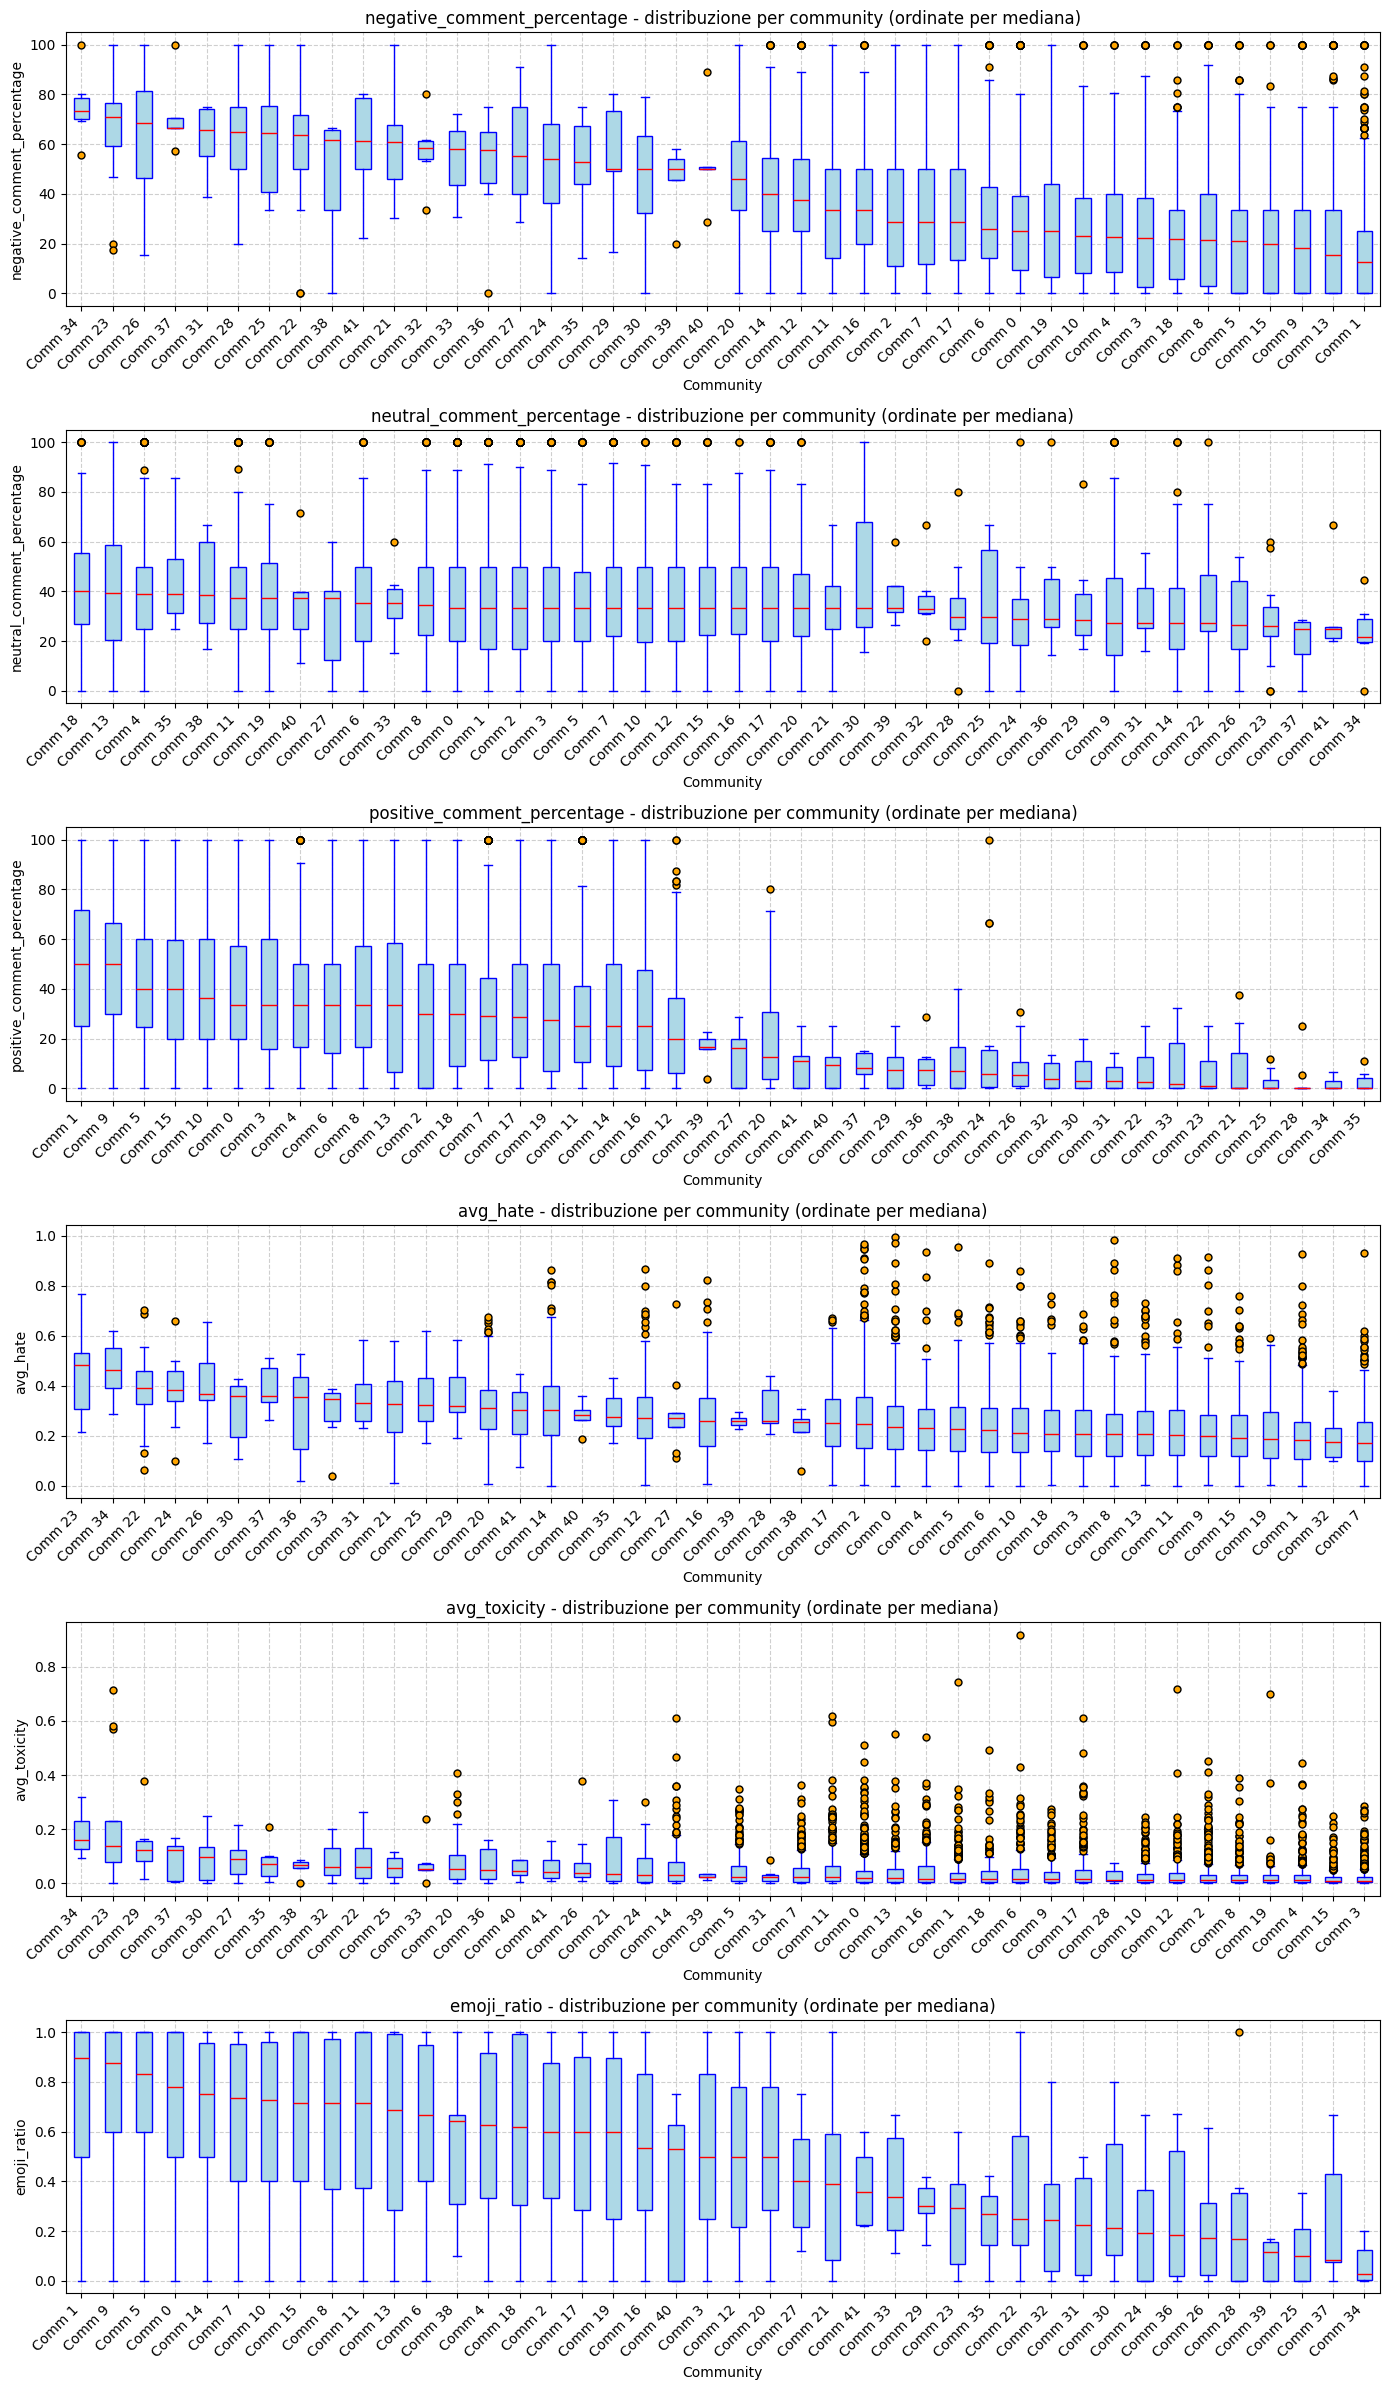

In [33]:
box_plot(leiden_mention_all, g1)

In [34]:
community_stats_leiden_mention_all = info_communities_negative_nodes(leiden_mention_all, node_data1)


📊 Distribution of negative nodes per community:
  Community 0: 270 / 836 (32.3% negative)
  Community 1: 148 / 753 (19.65% negative)
  Community 2: 273 / 645 (42.33% negative)
  Community 3: 216 / 617 (35.01% negative)
  Community 4: 154 / 476 (32.35% negative)
  Community 5: 124 / 467 (26.55% negative)
  Community 6: 174 / 456 (38.16% negative)
  Community 7: 190 / 438 (43.38% negative)
  Community 8: 147 / 420 (35.0% negative)
  Community 9: 84 / 416 (20.19% negative)
  Community 10: 141 / 411 (34.31% negative)
  Community 11: 203 / 402 (50.5% negative)
  Community 12: 242 / 391 (61.89% negative)
  Community 13: 109 / 337 (32.34% negative)
  Community 14: 163 / 287 (56.79% negative)
  Community 15: 65 / 242 (26.86% negative)
  Community 16: 118 / 228 (51.75% negative)
  Community 17: 97 / 221 (43.89% negative)
  Community 18: 66 / 196 (33.67% negative)
  Community 19: 71 / 167 (42.51% negative)
  Community 20: 114 / 157 (72.61% negative)
  Community 21: 25 / 26 (96.15% negative)
  C

In [35]:
correlation(community_stats_leiden_mention_all)

Correlation between total nodes and negative nodes (absolute count): 0.92
Correlation between total nodes and percentage of negative nodes: -0.85


In [36]:
avg_edge_leiden_mention_all = avg_edge_weight_per_community(leiden_mention_all, g1)

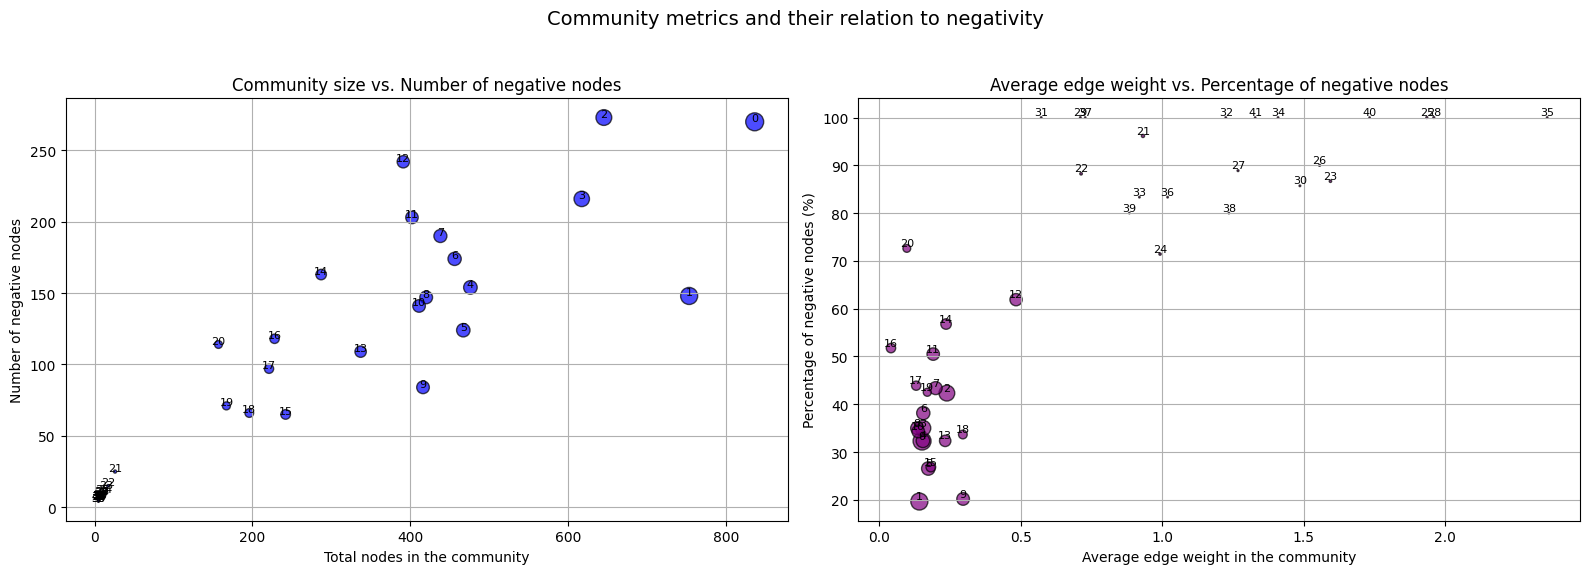

In [37]:
double_plot(community_stats_leiden_mention_all, avg_edge_leiden_mention_all)

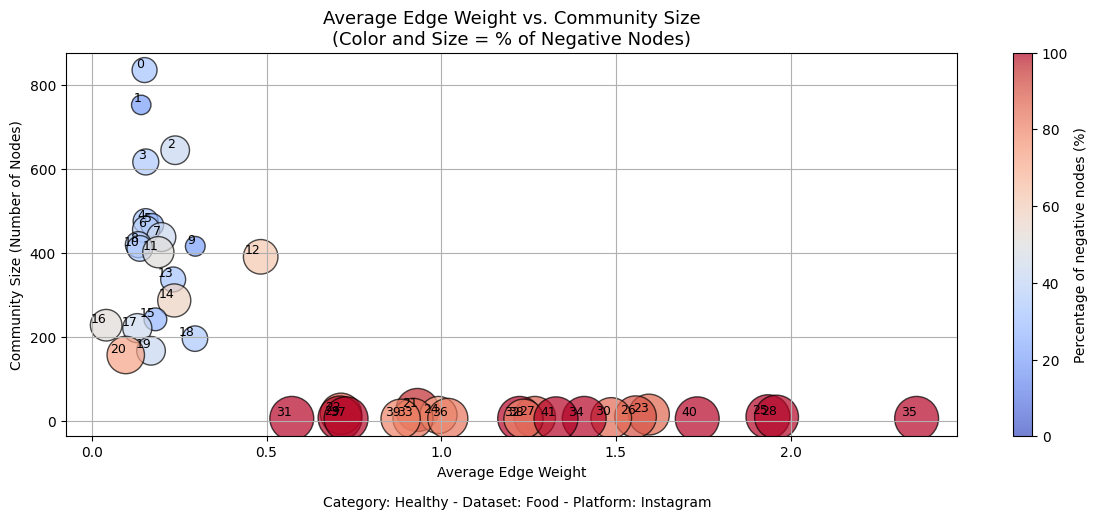

In [38]:
single_plot(community_stats_leiden_mention_all, avg_edge_leiden_mention_all, 'healthy_ig_mention', description = 'Category: Healthy - Dataset: Food - Platform: Instagram', save_path='fig_result')

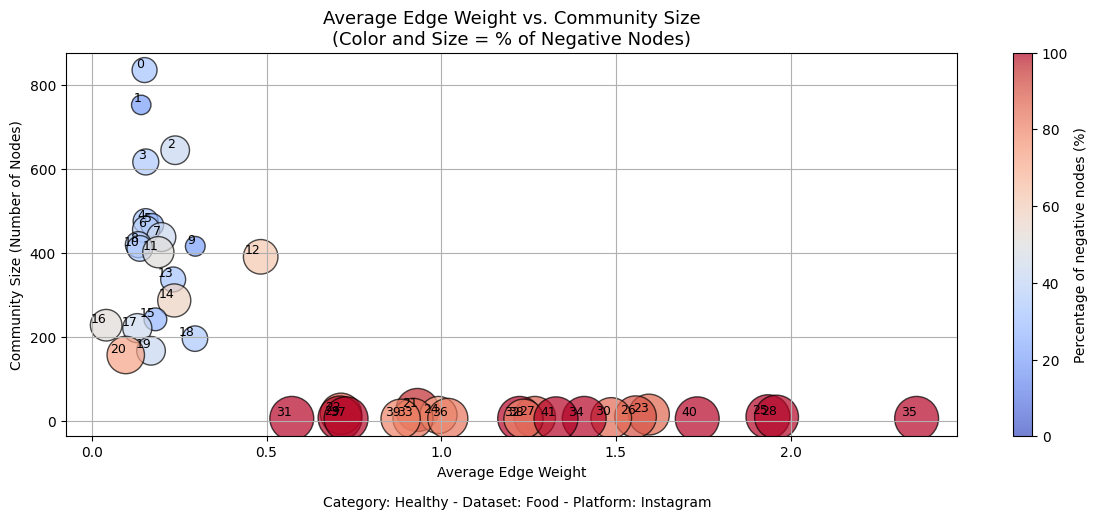

In [39]:
single_plot(community_stats_leiden_mention_all, avg_edge_leiden_mention_all, 'healthy_ig_mention', description = 'Category: Healthy - Dataset: Food - Platform: Instagram', save_path='fig_result')

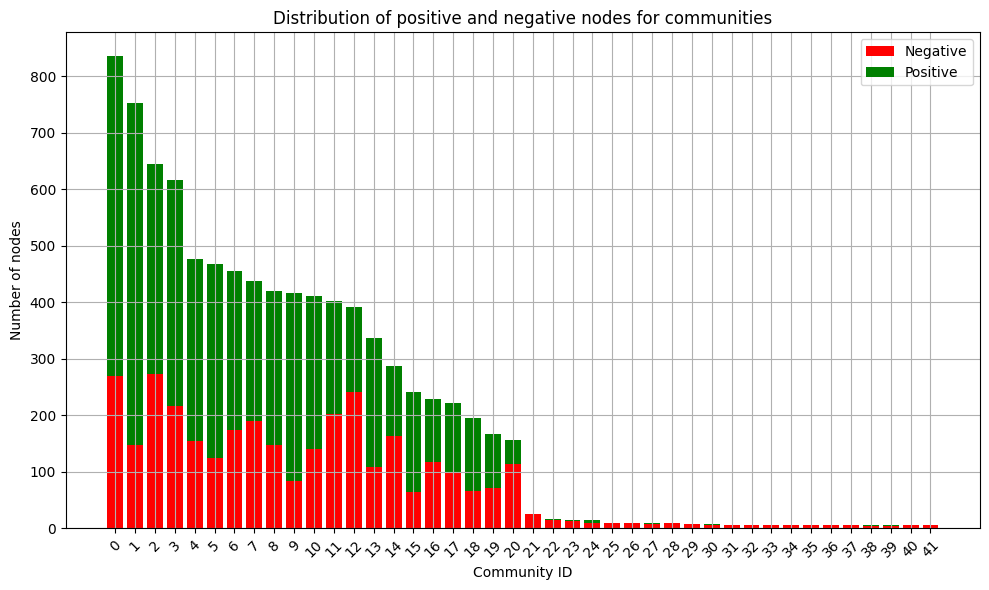

In [40]:
pos_neg_distribution_plot(community_stats_leiden_mention_all)

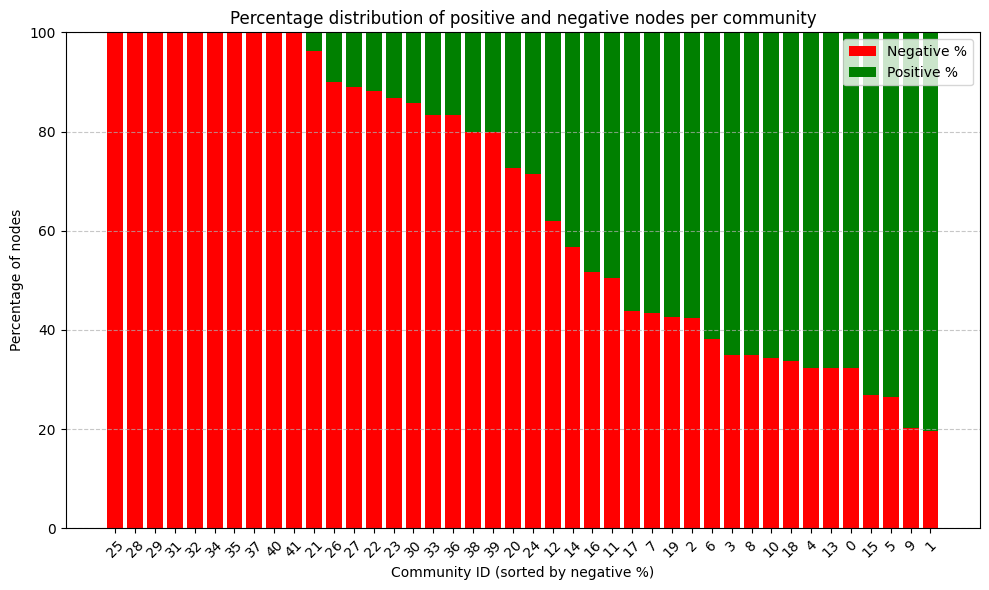

In [41]:
pos_neg_distribution_plot_percent(community_stats_leiden_mention_all)

## Rete globale

In [42]:
g2, node_data2 = apri_grafo(output_path, file_edge_global, file_node_att_global)

Nodi nella rete: 13922
Archi nella rete: 85068


### Componente più connessa

In [43]:
largest_ccG = max(nx.connected_components(g2), key=len)

G_connected = g2.subgraph(largest_ccG).copy()
len(G_connected)

13922

In [44]:
leiden_global_cc = apri_communities(output_path, file_leiden_global_cc)

In [45]:
leiden_dct_global_cc = communities_dct_stat(leiden_global_cc, g2)

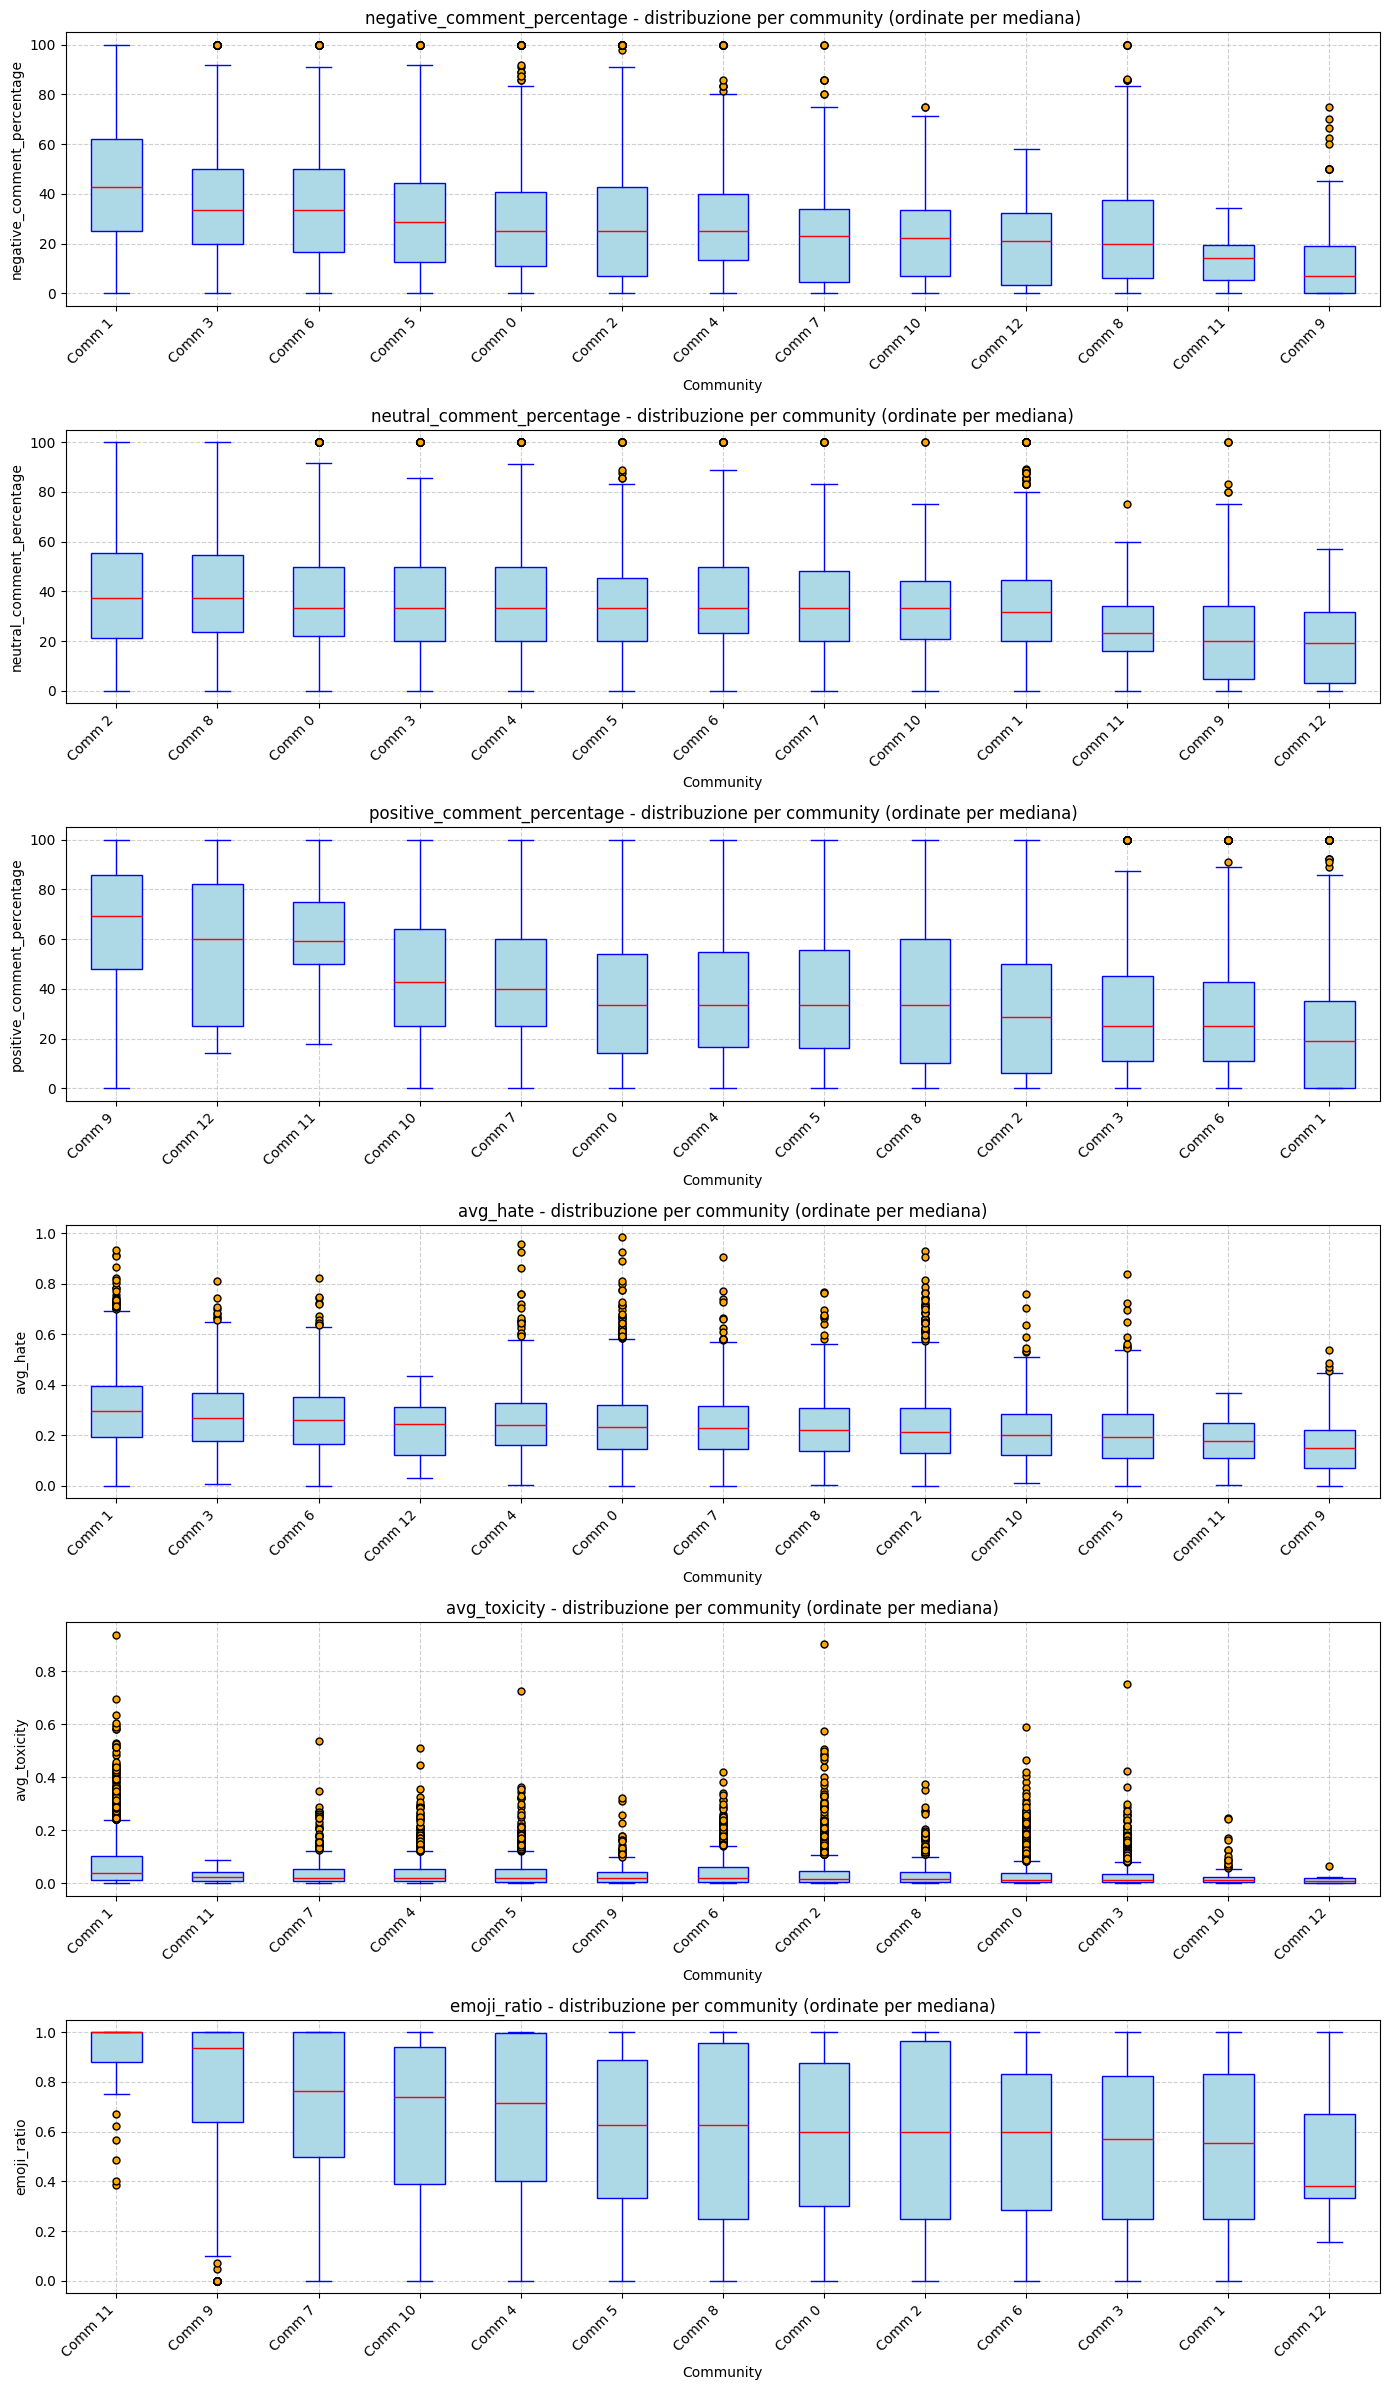

In [46]:
box_plot(leiden_global_cc, g2)

In [47]:
community_stats_leiden_global_cc = info_communities_negative_nodes(leiden_global_cc, node_data2)


📊 Distribution of negative nodes per community:
  Community 0: 1273 / 3185 (39.97% negative)
  Community 1: 1925 / 2981 (64.58% negative)
  Community 2: 637 / 1578 (40.37% negative)
  Community 3: 604 / 1198 (50.42% negative)
  Community 4: 445 / 1179 (37.74% negative)
  Community 5: 393 / 940 (41.81% negative)
  Community 6: 435 / 913 (47.65% negative)
  Community 7: 203 / 731 (27.77% negative)
  Community 8: 243 / 647 (37.56% negative)
  Community 9: 23 / 294 (7.82% negative)
  Community 10: 39 / 150 (26.0% negative)
  Community 11: 2 / 43 (4.65% negative)
  Community 12: 2 / 6 (33.33% negative)


In [48]:
correlation(community_stats_leiden_global_cc)

Correlation between total nodes and negative nodes (absolute count): 0.95
Correlation between total nodes and percentage of negative nodes: 0.67


In [49]:
avg_edge_leiden_global_cc = avg_edge_weight_per_community(leiden_global_cc, g2)

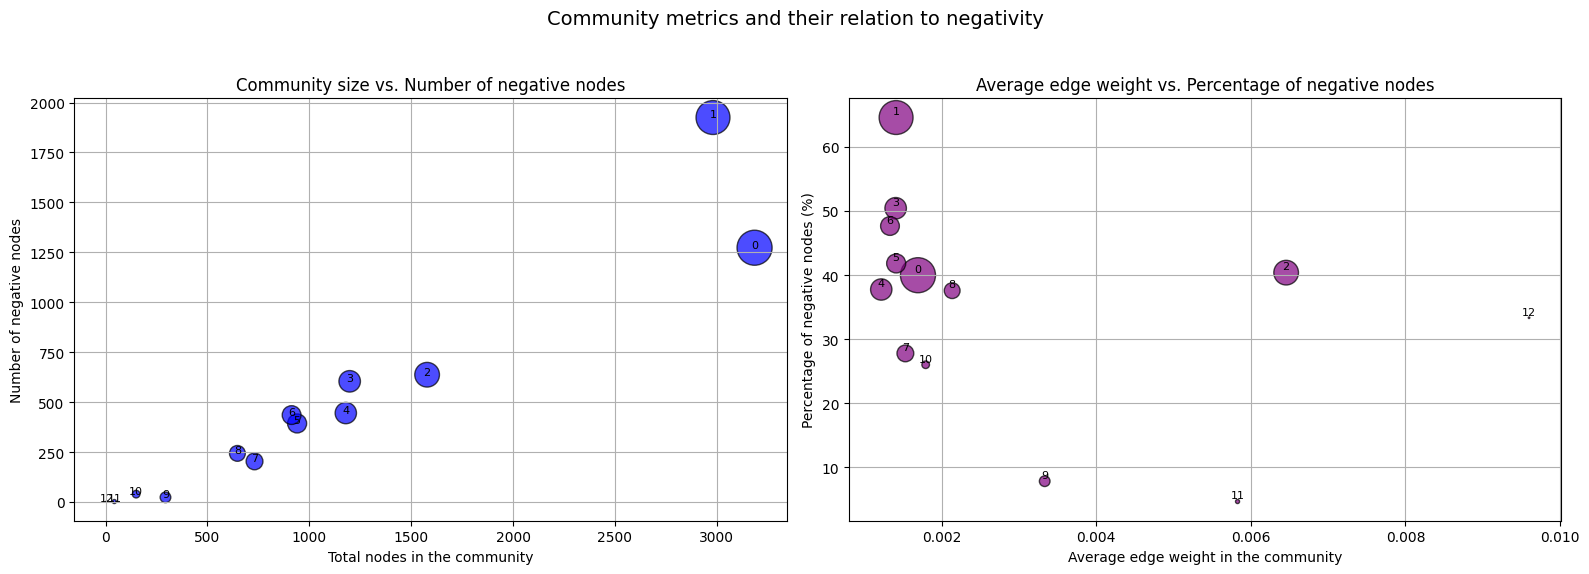

In [50]:
double_plot(community_stats_leiden_global_cc, avg_edge_leiden_global_cc)

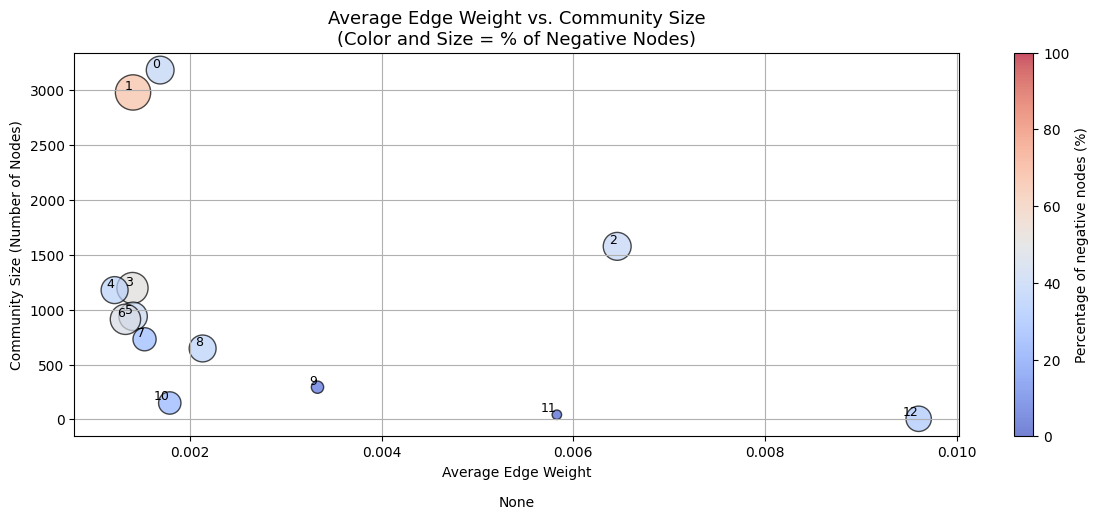

In [52]:
single_plot(community_stats_leiden_global_cc, avg_edge_leiden_global_cc, 'healthy_ig_cc_global')

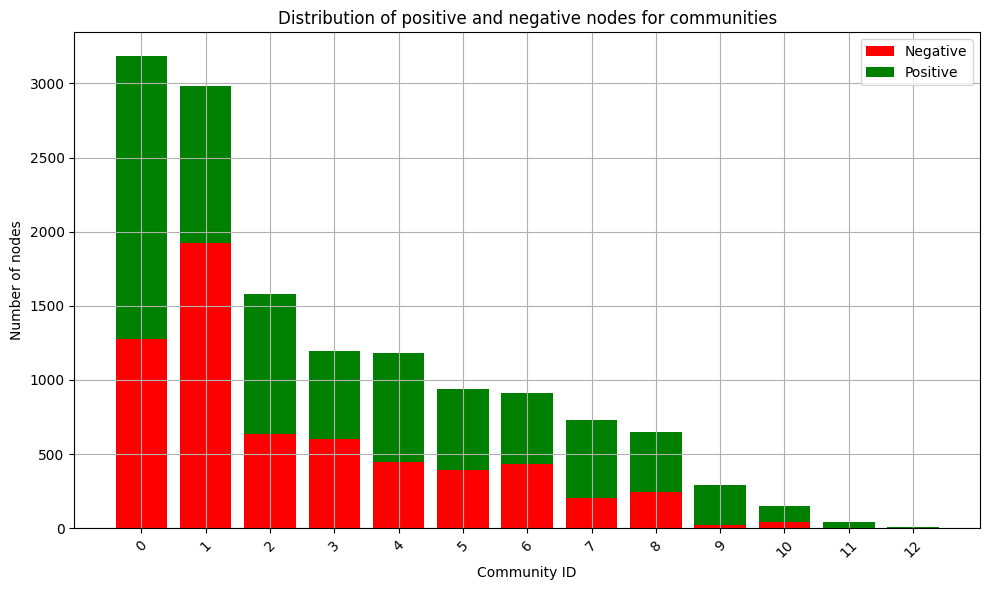

In [53]:
pos_neg_distribution_plot(community_stats_leiden_global_cc)

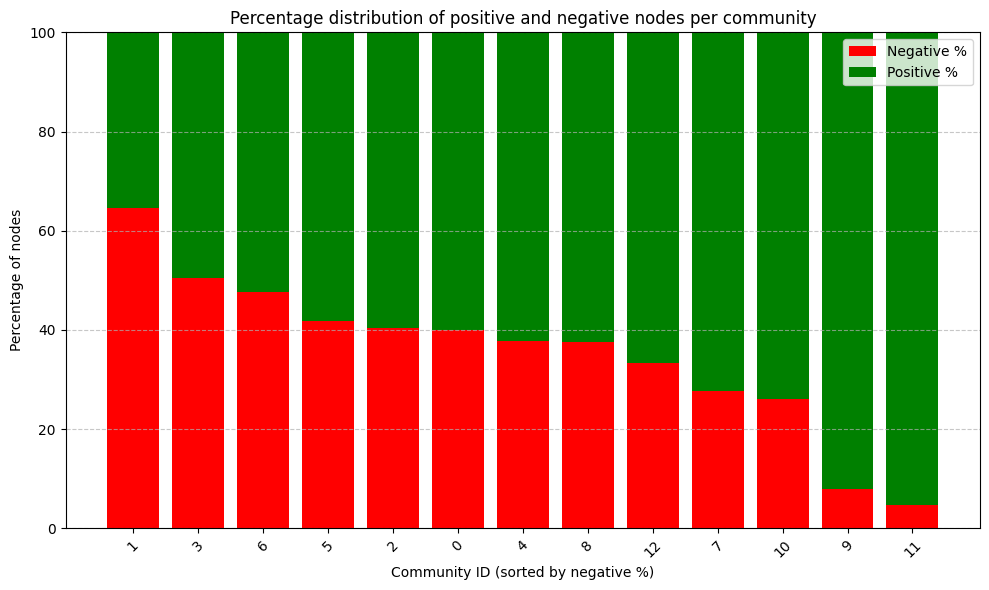

In [54]:
pos_neg_distribution_plot_percent(community_stats_leiden_global_cc)

### analisi sul grafo intero

In [55]:
leiden_global_all = apri_communities(output_path, file_leiden_global_all)

In [56]:
leiden_dct_global_all = communities_dct_stat(leiden_global_all, g2)

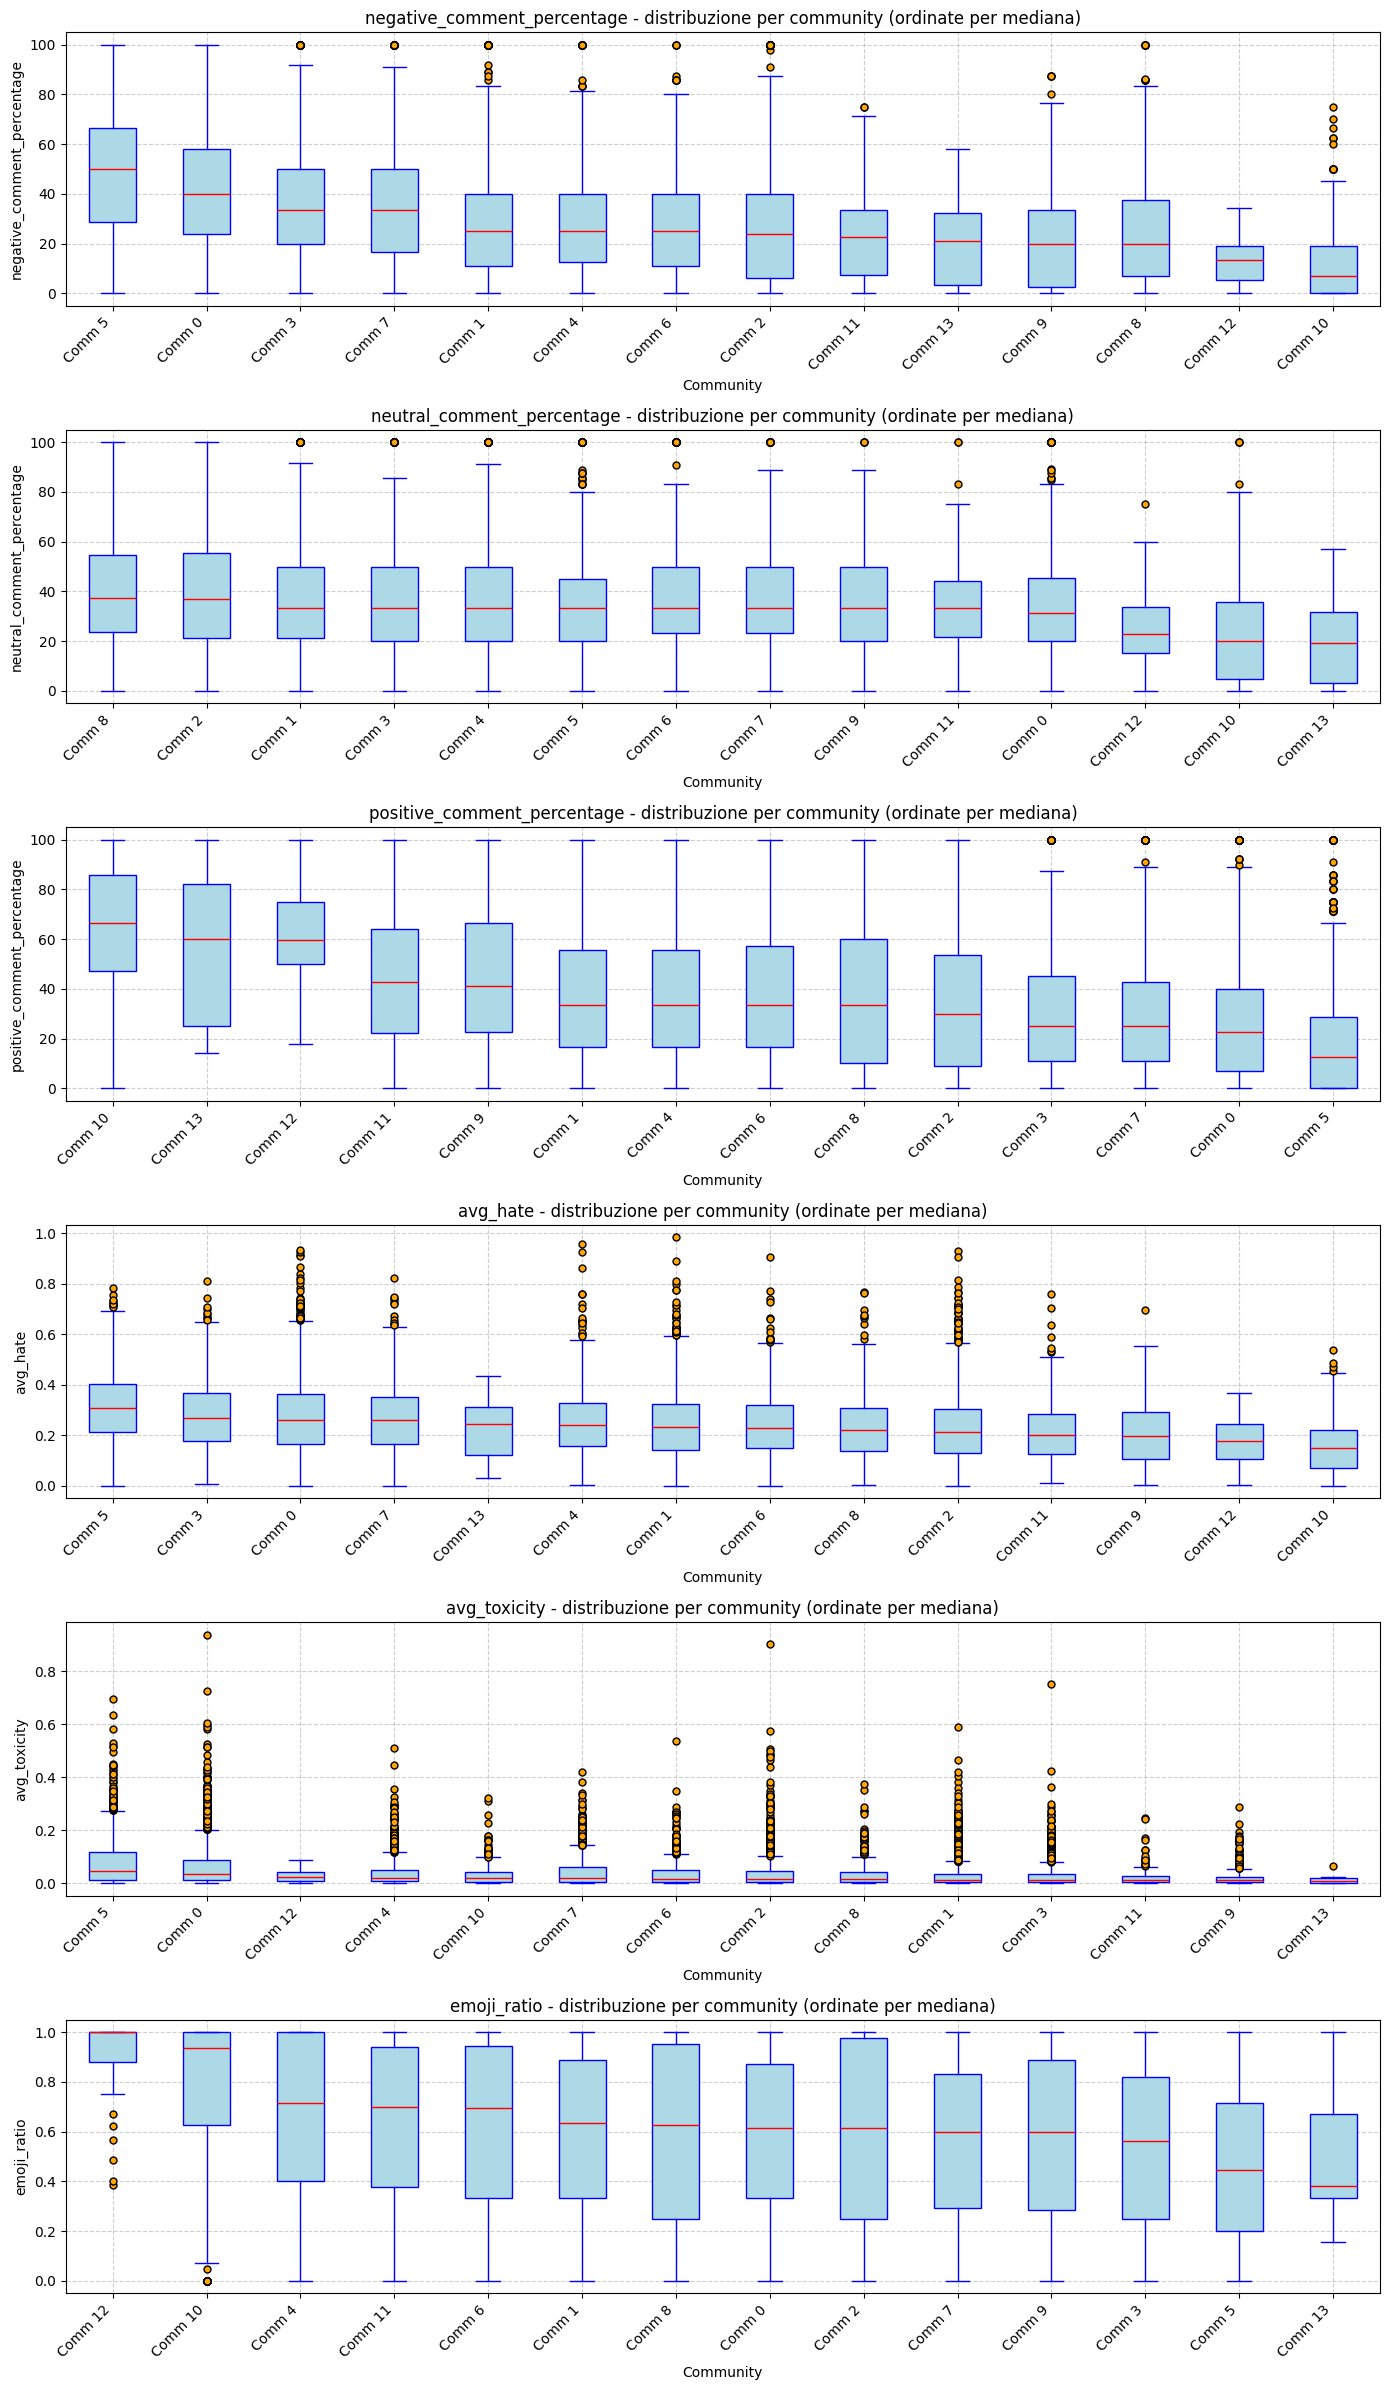

In [57]:
box_plot(leiden_global_all, g2)

In [58]:
community_stats_leiden_global_all = info_communities_negative_nodes(leiden_global_all, node_data2)


📊 Distribution of negative nodes per community:
  Community 0: 1487 / 2551 (58.29% negative)
  Community 1: 957 / 2521 (37.96% negative)
  Community 2: 663 / 1707 (38.84% negative)
  Community 3: 608 / 1204 (50.5% negative)
  Community 4: 432 / 1193 (36.21% negative)
  Community 5: 814 / 1124 (72.42% negative)
  Community 6: 398 / 1079 (36.89% negative)
  Community 7: 436 / 915 (47.65% negative)
  Community 8: 242 / 641 (37.75% negative)
  Community 9: 121 / 410 (29.51% negative)
  Community 10: 26 / 301 (8.64% negative)
  Community 11: 41 / 154 (26.62% negative)
  Community 12: 2 / 44 (4.55% negative)
  Community 13: 2 / 6 (33.33% negative)


In [59]:
correlation(community_stats_leiden_global_all)

Correlation between total nodes and negative nodes (absolute count): 0.94
Correlation between total nodes and percentage of negative nodes: 0.58


In [60]:
avg_edge_leiden_global_all = avg_edge_weight_per_community(leiden_global_all, g2)

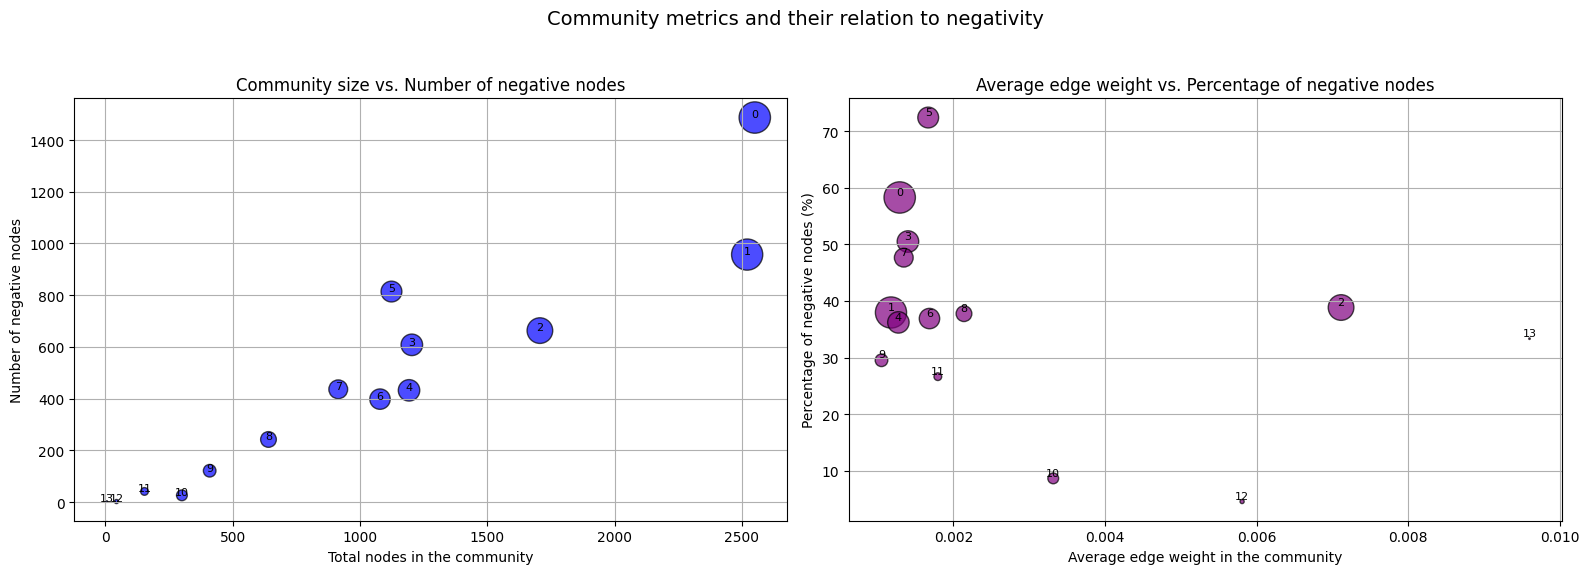

In [61]:
double_plot(community_stats_leiden_global_all, avg_edge_leiden_global_all)

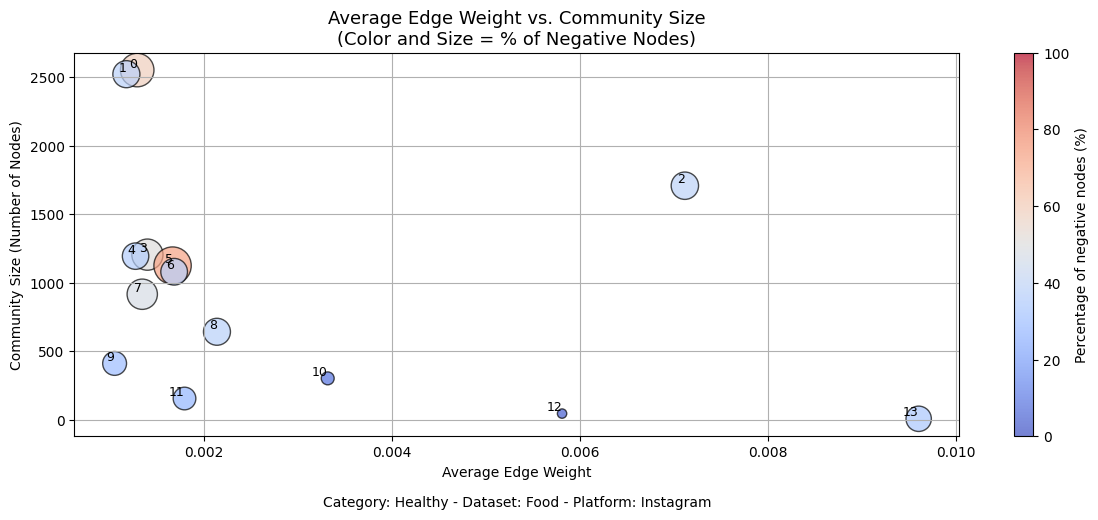

In [62]:
single_plot(community_stats_leiden_global_all, avg_edge_leiden_global_all, 'healthy_ig_global', description = 'Category: Healthy - Dataset: Food - Platform: Instagram', save_path='fig_result')

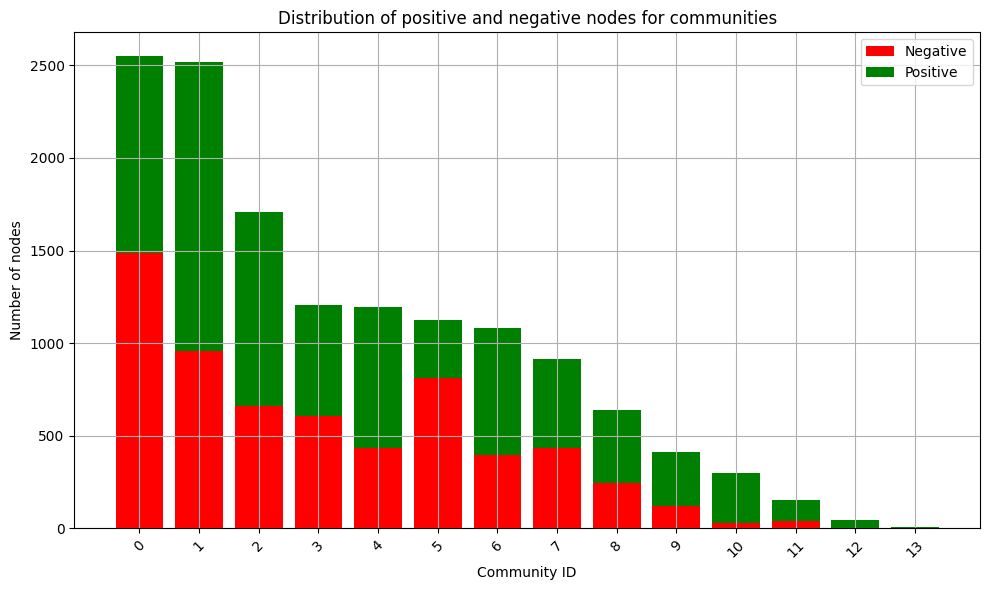

In [63]:
pos_neg_distribution_plot(community_stats_leiden_global_all)

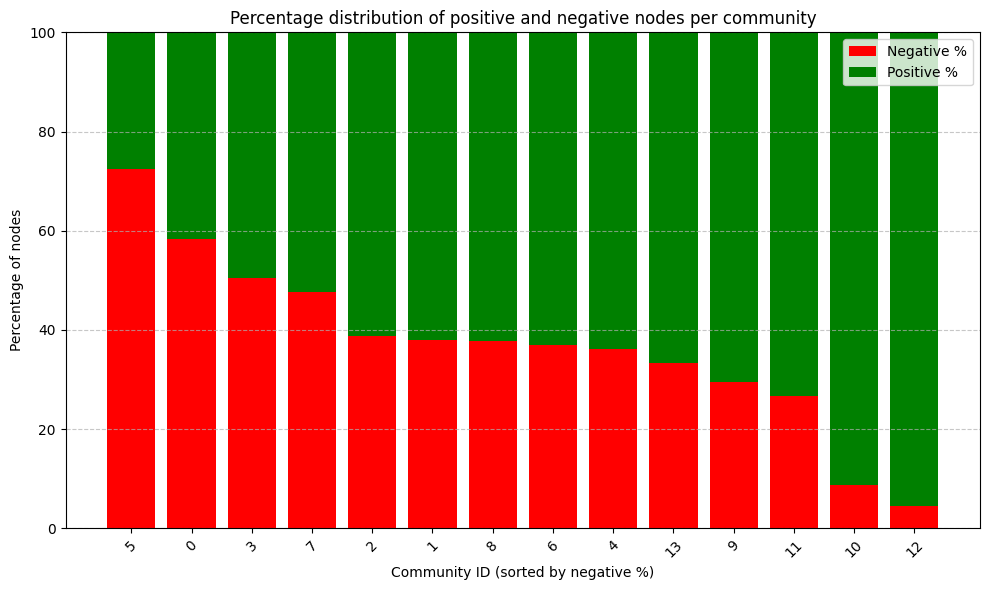

In [64]:
pos_neg_distribution_plot_percent(community_stats_leiden_global_all)